In [510]:
from functools import partial

import scipy
import numpy as np
from scipy.linalg import cholesky, cho_solve

import matplotlib
import matplotlib.pyplot as plt

## Gaussian Processes

We can define a GP by the following equations for the mean and covariance respectively,
$$
\begin{aligned}
\mathbb{E}\left[\mathbf{f}_*\right] & =K\left(X_*, X\right)\left[K(X, X)+\sigma_n^2 I\right]^{-1} \mathbf{y} \\
\operatorname{Cov}\left(\mathbf{f}_*\right) & 
 =K\left(X_*, X_*\right)-K\left(X_*, X\right)\left[K(X, X)+\sigma_n^2 I\right]^{-1} K\left(X, X_*\right)
\end{aligned}
$$
Where $X$ are the training samples, $X_*$ the test samples, $K$ the choice of kernel function e.g. the exponentiated quadratic, and $\sigma_n^2$ the signal noise if necessary.

In [495]:
def exponentiated_quadratic(xa, xb, length_scale=1):
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm / 2*length_scale**2)

n = 50
num_f = 10

X = np.expand_dims(np.linspace(-6, 6, n), 1)
# Kernel based on the datapoints
sigma = exponentiated_quadratic(X, X)

# Sample the prior at X
y = np.random.multivariate_normal(mean=np.zeros(n), cov=sigma, size=num_f)

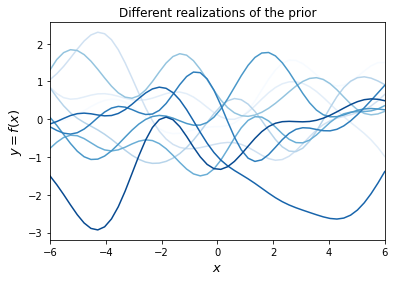

In [496]:
plt.figure(figsize=(6, 4))
cmap = matplotlib.colormaps.get_cmap('Blues')
colors = [cmap(i/num_f) for i in range(num_f)]

for i in range(num_f):
    plt.plot(X, y[i], linestyle='-', color=colors[i])
    
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title('Different realizations of the prior')
plt.xlim([-6, 6])
plt.show()

The algorithm as defined in 'Gaussian Processes for Machine Learning', is given as follows:

$$
\begin{array}{l}
\textbf{Gaussian Process} \\
\textbf{input: } X \text{ (inputs)}, y \text{ (targets)}, k \text{ (covariance function)}, \sigma_n^2 \text{ (noise level)}, x_* \text{ (test input)} \\
\quad L := \text{cholesky}(K + \sigma_n^2 I) \\
\quad \alpha := L^T \backslash (L \backslash y) \\
\quad f_* := k_*^T \alpha \quad \textit{(predictive mean)} \\
\quad v := L \backslash k_* \\
\quad \mathbb{V}[f_*] := k(x_*, x_*) - v^T v \quad \textit{(predictive variance)} \\
\quad \log p(y | X) := -\frac{1}{2} y^T \alpha - \sum_i \log L_{ii} - \frac{n}{2} \log 2\pi \\
\quad \textbf{return } f_*, \mathbb{V}[f_*], \log p(y | X) \text{ (log marginal likelihood)}
\end{array}
$$

Importantly, it does not rely on directly computing the inverse of the term $A = K + \sigma_n^2 I$ but instead uses a Cholesky Factorization, $A = LL^{\top}$. As they argue this is a faster and more numerically stable way to compute the inverse. The decomposition is then used to solve $A \mathbf{x} =\mathbf{b}$:

\begin{aligned}
A \mathbf{x} & =\mathbf{b} \\
L L^{\top} \mathbf{x} & =\mathbf{b} \\
L L^{\top} \mathbf{x} & =L \mathbf{y} \quad \text { for some } \mathbf{y} \\
L^{\top} \mathbf{x} & =\mathbf{y} .
\end{aligned}

Thus, if we can solve for $\mathbf{y}$ in $L \mathbf{y}=\mathbf{b}$, and then solve for $\mathbf{x}$ in $L^{\top} \mathbf{x}=\mathbf{y}$, we will have solved for the same $\mathbf{x}$ that solves $A \mathbf{x}=\mathbf{b}$. Let the notation $A \backslash \mathbf{b}$ denote the vector $\mathbf{x}$ that solves $A \mathbf{x}=\mathbf{b}$. Then we have

$$
\mathbf{x}=L^{\top} \backslash(L \backslash \mathbf{b})
$$

In [577]:
def generate_sin(n=8, n_=75, domain=(-6, 6)):
    f_sin = lambda x: (np.sin(x)).flatten()

    # Sample training samples (X1, y1)
    X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n, 1))
    y1 = f_sin(X1)

    # Test samples
    X2 = np.linspace(domain[0], domain[1], n_).reshape(-1, 1)
    return f_sin, X1, y1, X2

f_sin, X1, y1, X2 = generate_sin()

X1.shape, y1.shape, X2.shape

((8, 1), (8,), (75, 1))

In [498]:
class GaussianProcess:
    def __init__(self, kernel, noise_sigma: float = 0.0, length_scale: float = 1.0):
        self.kernel = kernel
        self.noise_sigma = noise_sigma
        self.length_scale = length_scale # TODO: Use it
    
    def fit(self, X, y):
        # Store the training points
        self.X = X
        
        K = self.kernel(X, X) + (self.noise_sigma ** 2) * np.eye(X.shape[0])
        self.L = cholesky(K, lower=True)
        self.alpha = cho_solve((self.L, True), y)
    
    def predict(self, X_):
        k_star = self.kernel(X_, self.X)
        f_mean = k_star.dot(self.alpha) # Mean

        v = cho_solve((self.L, True), k_star.T)
        f_cov = self.kernel(X_, X_) - k_star.dot(v) # Covariance
        return f_mean, f_cov
    

GP = GaussianProcess(kernel=exponentiated_quadratic)

# Number of samples to display
M = 8
GP.fit(X1[:M], y1[:M])
mean, cov = GP.predict(X2)

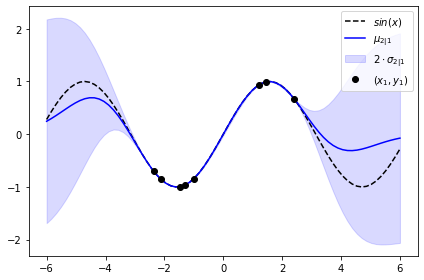

In [499]:
def plot_fit(mean, cov, X, y, f_true, X_):
    var = np.sqrt(np.diag(cov))
    
    plt.plot(X_, f_true(X_), 'k--', label='$sin(x)$')
    plt.plot(X_[:, 0], mean, color='b', label='$\mu_{2|1}$')
    plt.fill_between(X_[:, 0], mean-2*var, mean+2*var,
        color='b', alpha=0.15, label='$2 \cdot \sigma_{2|1}$')
    
    plt.plot(X, y, 'ko', linewidth=2, label='$(x_1, y_1)$')
    plt.legend()
    plt.tight_layout()
    
plot_fit(mean, cov, X=X1[:M], y=y1[:M], X_=X2, f_true=f_sin)

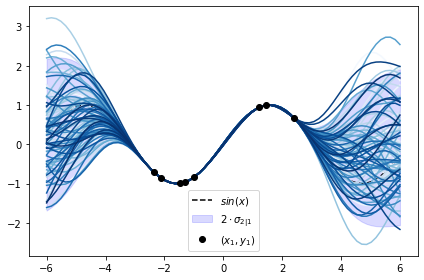

In [500]:
# Number of functions to sample from the posterior
num_f = 100
y_pred = np.random.multivariate_normal(mean, cov, size=num_f)

def plot_posterior(mean, cov, X, y, f_true, X_):
    var = np.sqrt(np.diag(cov))
    
    plt.plot(X_, f_true(X_), 'k--', label='$sin(x)$')
    plt.fill_between(X_[:, 0].flat, mean-2*var, mean+2*var,
        color='b', alpha=0.15, label='$2 \cdot \sigma_{2|1}$')
    
    # Colors
    cmap = matplotlib.colormaps.get_cmap('Blues')
    colors = [cmap(i/num_f) for i in range(num_f)]

    for i in range(y_pred.shape[0]):
        plt.plot(X_, y_pred[i].T, color=colors[i])

    plt.plot(X, y, 'ko', linewidth=2, label='$(x_1, y_1)$')
    plt.legend()
    plt.tight_layout()
    

plot_posterior(mean, cov, X1, y1, f_sin, X2)

How much difference is there between using the cholesky decomposition versus naive matrix inversion?

The difference starts to show whenever I greatly increase the samples, in the range of thousands. The algorithm uses Cholesky decomposition, instead of directly inverting the matrix, since it is faster and numerically more stable.

In [506]:
f_sin, X1, y1, X2 = generate_sin(n=1200, n_=15, domain=(-1000, 1000))

In [507]:
%%timeit
GP.fit(X1, y1)
mean, cov = GP.predict(X2)

54.7 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [508]:
def naive_inversion_fit(X, y, X_, kernel, noise_sigma = 0.0):
    K = kernel(X, X) + (noise_sigma ** 2) * np.eye(X.shape[0])    
    K_inv = np.linalg.inv(K)
    
    mean = kernel(X_, X) @ K_inv @ y
    cov  = kernel(X_, X_) - (kernel(X_, X) @ K_inv @ kernel(X, X_))
    return mean, cov

In [509]:
%%timeit
mean, cov = naive_inversion_fit(X1, y1, X2, kernel=exponentiated_quadratic)

197 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Marginal Likelihood
Add the Marginal Likelihood to the GP model.

In [516]:
class GaussianProcess:
    def __init__(self, kernel, noise_sigma: float = 0.0, length_scale: float = 1.0):
        self.kernel = partial(kernel, length_scale=length_scale)
        self.noise_sigma = noise_sigma
        self.length_scale = length_scale
    
    def fit(self, X, y):
        # Store the training points
        self.X = X
        self.y = y
        
        K = self.kernel(X, X) + (self.noise_sigma ** 2) * np.eye(X.shape[0])
        self.L = cholesky(K, lower=True)
        self.alpha = cho_solve((self.L, True), y)
    
    def predict(self, X_):
        k_star = self.kernel(X_, self.X)
        f_mean = k_star.dot(self.alpha) # Mean

        v = cho_solve((self.L, True), k_star.T)
        f_cov = self.kernel(X_, X_) - k_star.dot(v) # Covariance
        
        # log p(y|X)
        log_p = -1/2 * self.y.T.dot(self.alpha) - np.sum(np.diag(self.L)) - (self.X.shape[0]/2) * np.log(2 * np.pi)
        return f_mean, f_cov, log_p
    

f_sin, X1, y1, X2 = generate_sin()
GP = GaussianProcess(kernel=exponentiated_quadratic, length_scale=0.5)

GP.fit(X1, y1)
mean, cov, log_p = GP.predict(X2)

log_p

-37.74452427090067

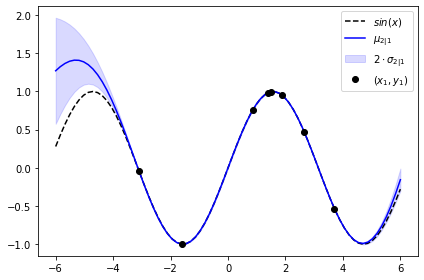

In [517]:
# Testing the length scale
plot_fit(mean, cov, X=X1, y=y1, X_=X2, f_true=f_sin)

-13.461528246038371

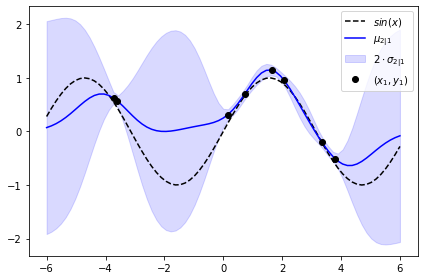

In [549]:
def generate_noisy_sin(n=8, n_=75, domain=(-6, 6)):
    f_sin = lambda x: (np.sin(x)).flatten()

    # Sample training samples (X1, y1)
    X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n, 1))
    y1 = f_sin(X1) + 0.2 * np.random.rand(X1.shape[0])

    # Test samples
    X2 = np.linspace(domain[0], domain[1], n_).reshape(-1, 1)
    return f_sin, X1, y1, X2

f_sin, X1, y1, X2 = generate_noisy_sin()
GP = GaussianProcess(kernel=exponentiated_quadratic, length_scale=1.5, noise_sigma=0.05)

GP.fit(X1, y1)
mean, cov, log_p = GP.predict(X2)


plot_fit(mean, cov, X=X1, y=y1, X_=X2, f_true=f_sin)

log_p

### Inducing Points
Attempt at inducing points without optimizing the parameters with conjugate gradients approach for now.

In [664]:
import numpy as np
from sklearn.cluster import KMeans

def select_inducing_points(X, num_points):
    kmeans = KMeans(n_clusters=num_points, random_state=0)
    kmeans.fit(X)

    # Get cluster centers as inducing points
    inducing_points = kmeans.cluster_centers_
    return inducing_points

num_points = 5
inducing_points = select_inducing_points(X1, num_points)
inducing_points

/Users/robvangastel/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[-1.03826306],
       [ 3.90995672],
       [-2.60273292],
       [-0.23480841],
       [-1.47026254]])

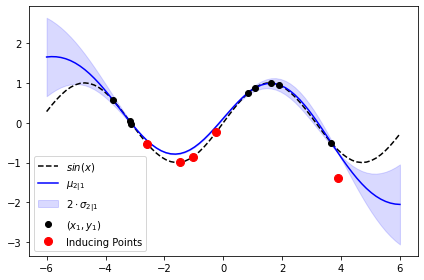

In [687]:
class GaussianProcess:
    def __init__(self, kernel, noise_sigma: float = 0.001, length_scale: float = 1.0):
        self.kernel = partial(kernel, length_scale=length_scale)
        self.noise_sigma = noise_sigma
        self.length_scale = length_scale
    
    def fit(self, X, y, X_inducing):
        # Store the training points
        self.X_inducing = X_inducing
        self.X = X
        self.y = y
        
        # Calculate K_uu inverse
        self.Kuu = self.kernel(X_inducing, X_inducing) + (self.noise_sigma ** 2) * np.eye(X_inducing.shape[0])
        self.K_inv = np.linalg.inv(self.Kuu)
        
        # Calculate mu
        K_uu = self.kernel(self.X_inducing, self.X_inducing)
        K_nu = self.kernel(X, self.X_inducing)
        K_un = K_nu.T
        
        precision = (1.0 / self.noise_sigma **2)
        Sigma = np.linalg.inv(K_uu + precision * K_un @ K_nu)
        self.mu_u = precision * (K_uu @ Sigma @ K_un).dot(y)
    
        # Calculate A_m
        self.A_m = K_uu @ Sigma @ K_uu
        
        
    def predict(self, X_):
        K_ss = self.kernel(X_, X_)
        K_su = self.kernel(X_, self.X_inducing)
        K_us = K_su.T

        f_q = (K_su @ self.K_inv).dot(self.mu_u)
        f_q_cov = K_ss - K_su @ self.K_inv @ K_us + K_su @ self.K_inv @ self.A_m @ self.K_inv @ K_us

        return f_q, f_q_cov
        
        
        
f_sin, X1, y1, X2 = generate_sin()
GP = GaussianProcess(kernel=exponentiated_quadratic, length_scale=0.5)
GP.fit(X1, y1, inducing_points)
mean, cov = GP.predict(X2)

mean_inducing, _ = GP.predict(inducing_points)

plot_fit_inducing(mean, cov, X=X1, y=y1, X_=X2, f_true=f_sin,
         X_inducing=inducing_points, y_inducing=mean_inducing)